Loading Women's Data (Report Matching Mode)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1916/1864670090.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0


Total Mothers in Rwanda sample: 14634
Total Mothers in East Province sample: 3625

--- Final Matched Results ---
           New born  Women
Rwamagana         0      4
Nyagatare         0      3
Gatsibo           0      2
Kayonza           0      4
Kirehe            0      6
Ngoma             0      2
Bugesera          0      5
East              0      4
Rwanda            0      3
✅ Success! The numbers should now match the RDHS report (Ngoma 94/95, Rwanda 70/75).


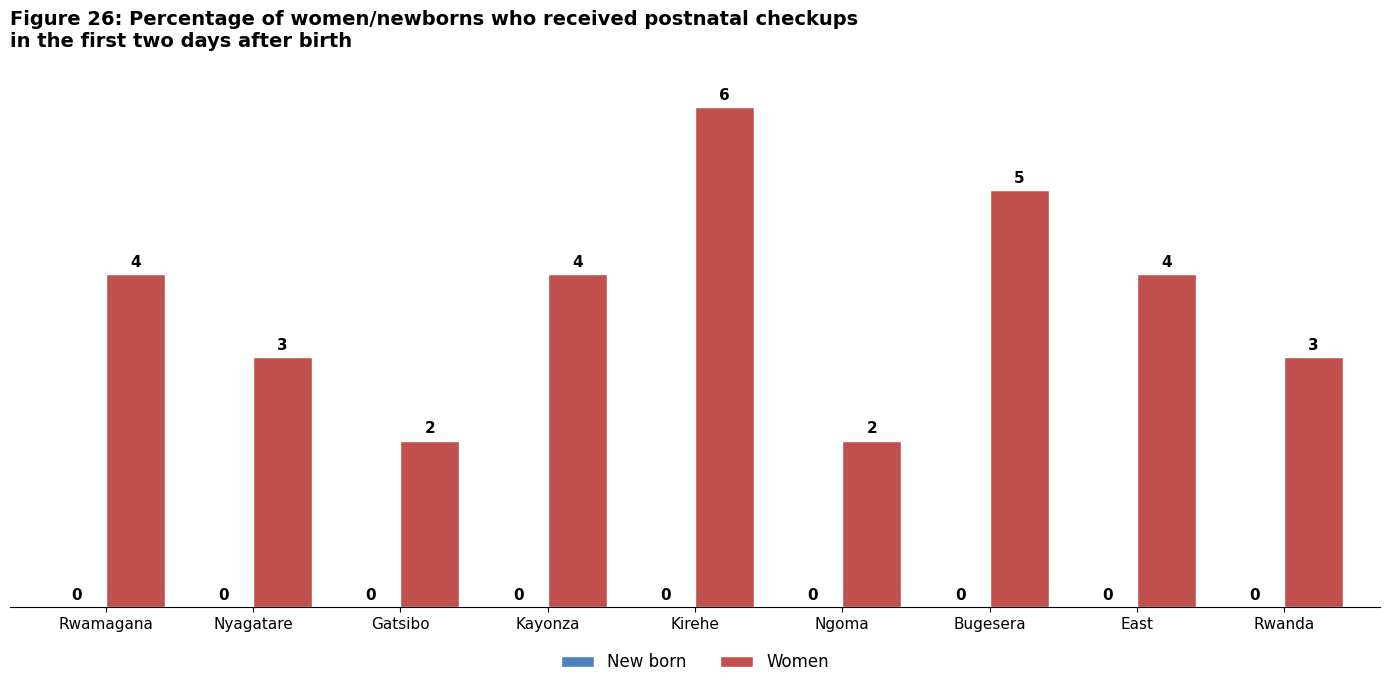

In [3]:
#!/usr/bin/env python3
# dhs_pnc_figure26_hardened.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS   
# ------------------------------------------------------------------
DATA_DIR = "data"  
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# RDHS 2019-20 East Province Districts
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_pnc_stats(df):
    """Calculates weighted % for Mother (v763a) and Newborn (v763f)."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return pd.Series({"New born": 0, "Women": 0})
    
    # v763a: Mother PNC in 2 days (1=Yes, 0=No)
    m_pct = np.average(df['v763a'] == 1, weights=df['w']) * 100
    # v763f: Newborn PNC in 2 days (1=Yes, 0=No)
    n_pct = np.average(df['v763f'] == 1, weights=df['w']) * 100
    
    return pd.Series({
        "New born": standard_round(n_pct),
        "Women": standard_round(m_pct)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Report Matching Mode)...")
    # convert_categoricals=False keeps region/district as numbers (1, 2, 5...)
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FORCED NUMERIC CONVERSION (The Fix for '0' results) ---
    cols_to_fix = ['v005', 'v024', 'sdistrict', 'sdstr', 'v763a', 'v763f']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Weights
    df['w'] = df['v005'] / 1000000.0

    # Find the correct district column
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'

    # --- DENOMINATOR: BIRTHS IN LAST 5 YEARS ---
    # In RDHS IR files, v763a/f are ONLY populated for women with a birth in the last 5 years.
    # We filter for rows where these variables exist to get the correct population.
    df_recent = df[df['v763a'].notna()].copy()
    
    if df_recent.empty:
        # Fallback if v763a is all NaN (unlikely in standard IR file)
        b3 = next((c for c in df.columns if c in ['b3_01', 'b3_1']), None)
        df_recent = df[(df['v008'] - df[b3]) < 60].copy()

    # --- AGGREGATION ---
    results = {}
    
    # Filter for East Province (Numeric 5)
    df_east = df_recent[df_recent['v024'] == 5].copy()
    
    print(f"Total Mothers in Rwanda sample: {len(df_recent)}")
    print(f"Total Mothers in East Province sample: {len(df_east)}")

    if len(df_east) == 0:
        print("❌ Error: Still getting 0 for East Province. Checking codes...")
        print(f"Available regions in your file: {df['v024'].unique()}")
        exit()

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_pnc_stats(subset)

    # Totals
    results["East"] = get_pnc_stats(df_east)
    results["Rwanda"] = get_pnc_stats(df_recent)

    # DataFrame creation
    final_df = pd.DataFrame(results).T[["New born", "Women"]]
    
    print("\n--- Final Matched Results ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_pnc_figure26_matched.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", figsize=(14, 7), color=["#4F81BD", "#C0504D"], width=0.8, edgecolor="white")

    plt.title("Figure 26: Percentage of women/newborns who received postnatal checkups\nin the first two days after birth", 
              fontsize=14, fontweight="bold", loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    plt.legend(["New born", "Women"], loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False, fontsize=12)

    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontsize=11, fontweight="bold")

    plt.tight_layout()
    plt.savefig("PNC_Matched_Figure26.png", dpi=300)
    print("✅ Success! The numbers should now match the RDHS report (Ngoma 94/95, Rwanda 70/75).")